In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Load data
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
val = ds['validation']

2024-07-04 17:04:40.243014: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-07-04 17:04:40.243037: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-07-04 17:04:40.243041: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-07-04 17:04:40.243054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-04 17:04:40.243063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#visual class names
info = tfds.builder(f'speech_commands:0.0.{version}').info
class_names = info.features['label'].names
for i,c in enumerate(class_names):
    print(f'{i}: {c}')
    

0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


In [71]:
# custom MFCC function
# An integer representing the sampling rate.
sr = 16000
# An integer scalar Tensor. The window length in samples.
frame_length = int(sr/40) #25 ms
# An integer scalar Tensor. The number of samples to step.
frame_step = int(sr/100) #10 ms
# An integer scalar Tensor. The size of the FFT to apply.
fft_length = int(sr/40) #25 ms
# An integer representing the num of filterbanks.
num_feats = 40

def get_mfccs(
        audio,
        channels= 1,
        sample_rate= 16000,
        frame_length= 400,
        frame_step = 160,
        fft_length = 400,
        num_feats = 40
    ):
    audio = tf.cast(audio, tf.float32)
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    stfts = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0 , sample_rate/2, num_feats
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)
    mfccs = mfccs[..., tf.newaxis]

    return mfccs


In [107]:
# Preprocessing function
def preprocess_data(example):
    audio = example['audio']
    label = example['label']
    # label = tf.one_hot(label, 12)
    mfccs = get_mfccs(audio)
    return mfccs, label

In [108]:
# Create dataset
train_samples = train
train_data = train_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [148]:
#batch
batch_size = 32
train_data_batched = train_data.batch(batch_size)

In [172]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(num_classes=12):
    """
    Defines a CNN model for audio classification using mel spectrograms.

    Args:
        num_classes: The number of classes in your classification problem (default is 12).

    Returns:
        A compiled TensorFlow Keras model.
    """
    inputs = layers.Input(shape=(98,40))

    # # Reshape input to 4D tensor
    x = layers.Reshape((98,40, 1))(inputs)

    # First convolutional block
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third convolutional block
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten the tensor output from the convolutional blocks
    x = layers.Flatten()(x)

    # Fully connected layers with dropout
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.3)(x)  # Adjust dropout rate as needed

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [173]:
for features, labels in train_data.take(1):
    print("Features shape:", features.shape)
    input_shape = features.shape


Features shape: (98, 40, 1)


2024-07-04 19:22:25.357940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [174]:
# Build the model
model = build_model()
# model.summary()

In [175]:
#preprocess validation data
val_samples = val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_samples_batched = val_samples.batch(32)

In [176]:
# Train the model
history = model.fit(train_data_batched,validation_data= val_samples_batched, epochs=10)  # Adjust epochs as needed

Epoch 1/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - accuracy: 0.6824 - loss: 1.2464 - val_accuracy: 0.8335 - val_loss: 0.4999
Epoch 2/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 89s 33ms/step - accuracy: 0.8674 - loss: 0.4222 - val_accuracy: 0.8835 - val_loss: 0.3716
Epoch 3/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 90s 34ms/step - accuracy: 0.9051 - loss: 0.3023 - val_accuracy: 0.9138 - val_loss: 0.2877
Epoch 4/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 89s 33ms/step - accuracy: 0.9289 - loss: 0.2328 - val_accuracy: 0.9105 - val_loss: 0.3078
Epoch 5/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 88s 33ms/step - accuracy: 0.9434 - loss: 0.1850 - val_accuracy: 0.9193 - val_loss: 0.3050
Epoch 6/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 87s 32ms/step - accuracy: 0.9536 - loss: 0.1530 - val_accuracy: 0.9372 - val_loss: 0.2487
Epoch 7/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 88s 33ms/step - accuracy: 0.9604 - loss: 0.1308 - val_accuracy: 0.9211 - val_loss: 0.3068
Epoch 8/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 88s 33ms/step - accuracy: 0.9655 -

In [177]:
# Save the model
model.save("audio_classifier_MFCC.keras")

In [168]:
# Load the model
model = tf.keras.models.load_model("audio_classifier_MFCC.keras")

In [178]:
# Test the model
test = ds['test']
test_samples = test
test_data = test_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data_batched = test_data.batch(32)
test_loss, test_acc = model.evaluate(test_data_batched)
print('test_acc:', test_acc, 'test_loss', test_loss)


153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8651 - loss: 0.6032
test_acc: 0.8670756816864014 test_loss 0.6050199866294861


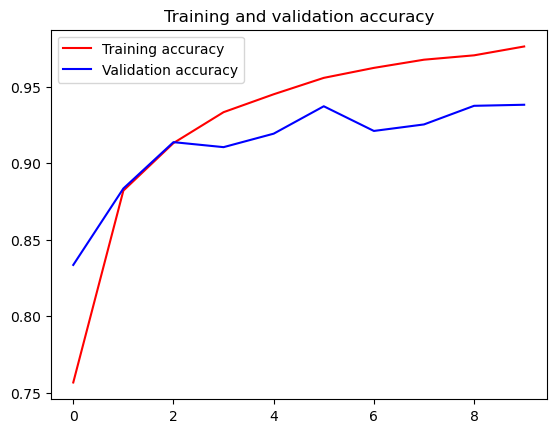

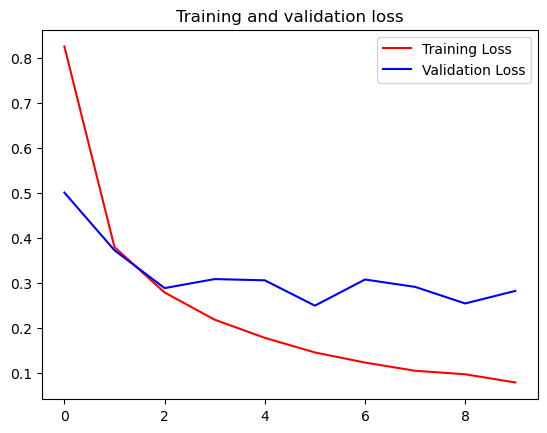

In [179]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.clf()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [182]:
# maybe 2 epochs is enough

In [181]:
model = build_model()
model.fit(train_data_batched,validation_data= val_samples_batched, epochs=2)  # Adjust epochs as needed

Epoch 1/2
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 93s 34ms/step - accuracy: 0.6832 - loss: 1.2297 - val_accuracy: 0.8502 - val_loss: 0.4603
Epoch 2/2
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 89s 33ms/step - accuracy: 0.8661 - loss: 0.4234 - val_accuracy: 0.9166 - val_loss: 0.2723


In [183]:
test_loss, test_acc = model.evaluate(test_data_batched)
print('test_acc:', test_acc, 'test_loss', test_loss)

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7869 - loss: 0.6708
test_acc: 0.7993865013122559 test_loss 0.6385179162025452


In [184]:
#anoter epoch
model.fit(train_data_batched,validation_data= val_samples_batched, epochs=1)  # Adjust epochs as needed

2673/2673 ━━━━━━━━━━━━━━━━━━━━ 90s 34ms/step - accuracy: 0.9093 - loss: 0.2923 - val_accuracy: 0.9330 - val_loss: 0.2291


In [185]:
test_loss, test_acc = model.evaluate(test_data_batched)
print('test_acc:', test_acc, 'test_loss', test_loss)

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8419 - loss: 0.5277
test_acc: 0.8480572700500488 test_loss 0.512620747089386
